Training: 100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


neuron (64, 32)
dropout 0.1
epoch num 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.57      0.52      0.55      2498
       Relay       0.50      0.55      0.52      2166

    accuracy                           0.54      4664
   macro avg       0.54      0.54      0.54      4664
weighted avg       0.54      0.54      0.54      4664



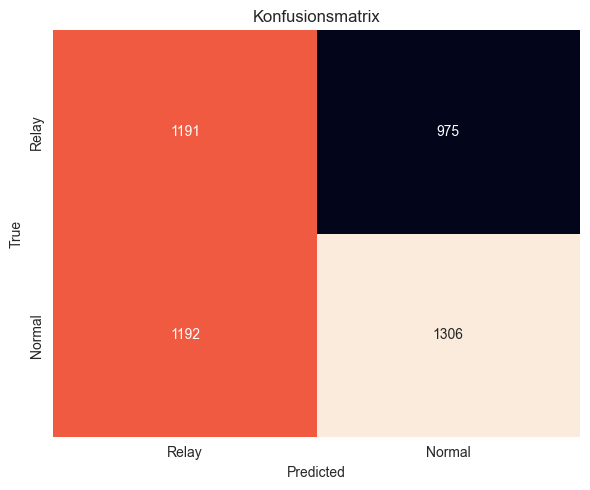

Training: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


neuron (64, 32)
dropout 0.1
epoch num 100

Classification Report:
               precision    recall  f1-score   support

      Normal       0.54      0.52      0.53      2498
       Relay       0.47      0.49      0.48      2166

    accuracy                           0.51      4664
   macro avg       0.51      0.51      0.51      4664
weighted avg       0.51      0.51      0.51      4664



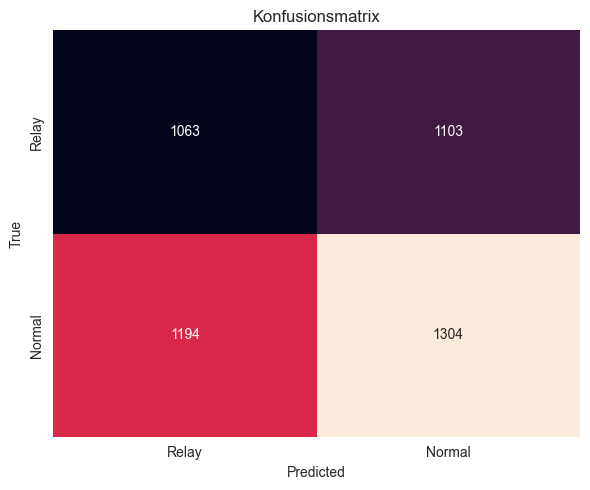

Training: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


neuron (64, 32)
dropout 0.1
epoch num 50

Classification Report:
               precision    recall  f1-score   support

      Normal       0.55      0.52      0.53      2498
       Relay       0.48      0.51      0.49      2166

    accuracy                           0.51      4664
   macro avg       0.51      0.51      0.51      4664
weighted avg       0.52      0.51      0.51      4664



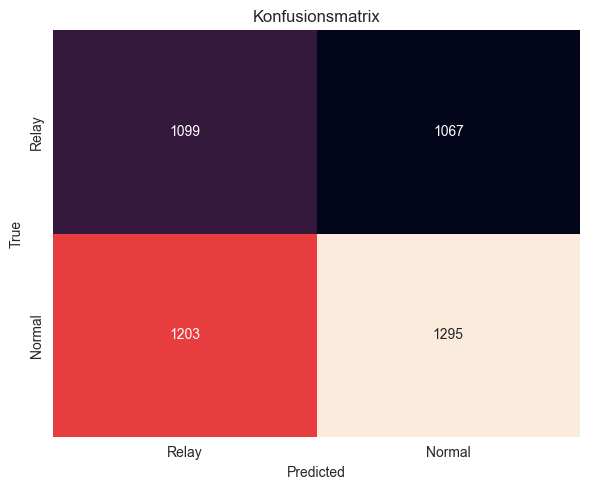

Training: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


neuron (64, 32)
dropout 0.2
epoch num 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.54      0.51      0.52      2498
       Relay       0.47      0.50      0.48      2166

    accuracy                           0.50      4664
   macro avg       0.50      0.50      0.50      4664
weighted avg       0.51      0.50      0.50      4664



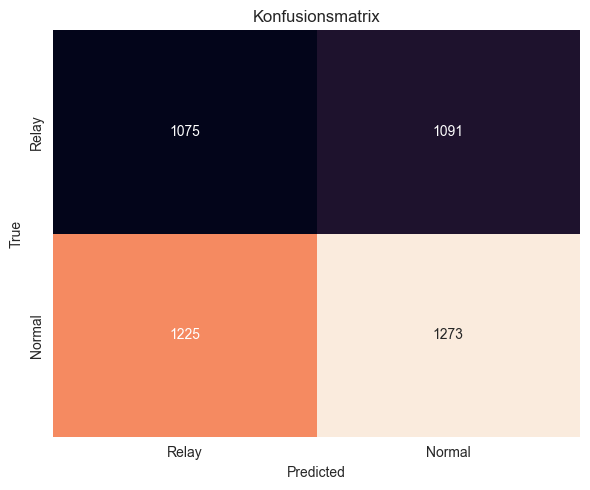

Training: 100%|██████████| 100/100 [02:10<00:00,  1.30s/it]


neuron (64, 32)
dropout 0.2
epoch num 100

Classification Report:
               precision    recall  f1-score   support

      Normal       0.53      0.52      0.53      2498
       Relay       0.46      0.48      0.47      2166

    accuracy                           0.50      4664
   macro avg       0.50      0.50      0.50      4664
weighted avg       0.50      0.50      0.50      4664



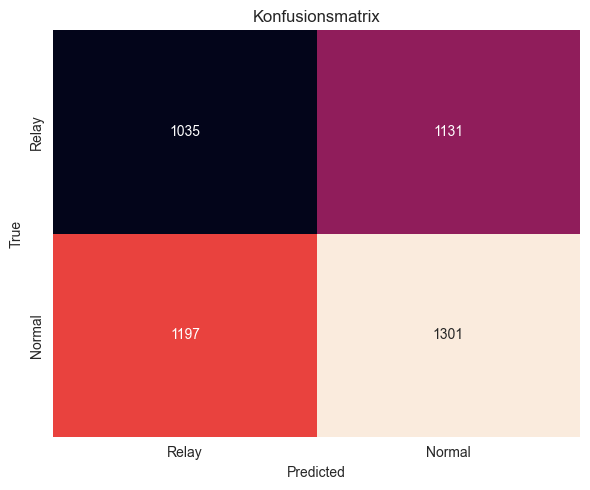

Training: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


neuron (64, 32)
dropout 0.2
epoch num 50

Classification Report:
               precision    recall  f1-score   support

      Normal       0.54      0.52      0.53      2498
       Relay       0.47      0.48      0.47      2166

    accuracy                           0.50      4664
   macro avg       0.50      0.50      0.50      4664
weighted avg       0.50      0.50      0.50      4664



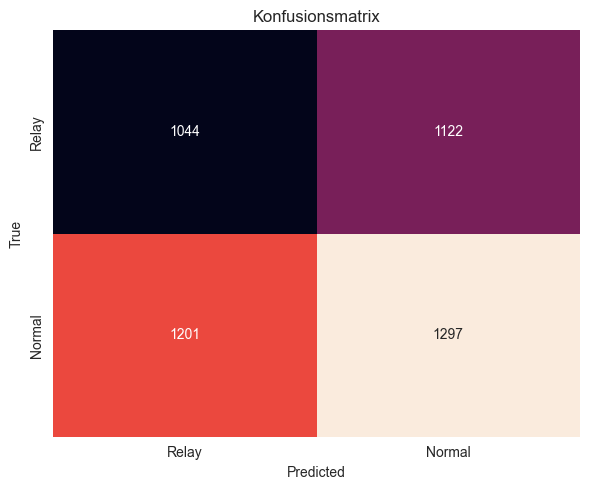

Training: 100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


neuron (64, 32)
dropout 0.3
epoch num 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.54      0.52      0.53      2498
       Relay       0.47      0.49      0.48      2166

    accuracy                           0.50      4664
   macro avg       0.50      0.50      0.50      4664
weighted avg       0.51      0.50      0.51      4664



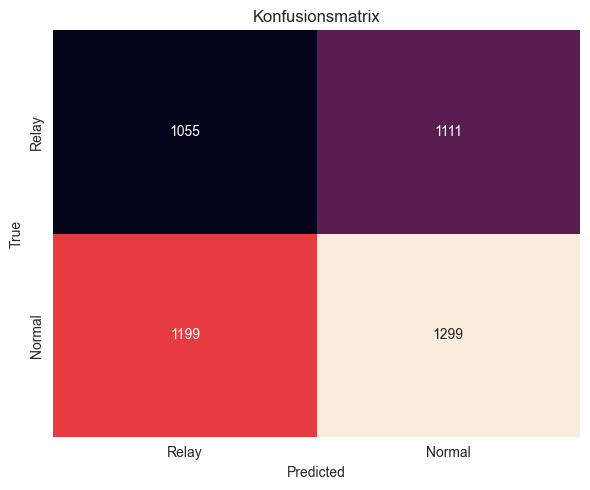

Training: 100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


neuron (64, 32)
dropout 0.3
epoch num 100

Classification Report:
               precision    recall  f1-score   support

      Normal       0.54      0.53      0.53      2498
       Relay       0.47      0.48      0.47      2166

    accuracy                           0.50      4664
   macro avg       0.50      0.50      0.50      4664
weighted avg       0.50      0.50      0.50      4664



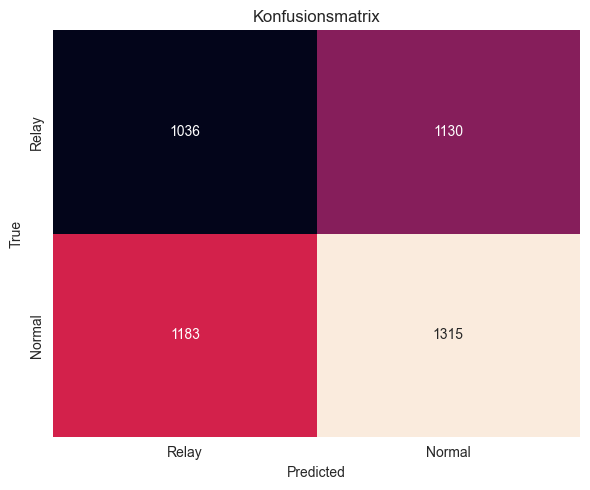

Training: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


neuron (64, 32)
dropout 0.3
epoch num 50

Classification Report:
               precision    recall  f1-score   support

      Normal       0.54      0.52      0.53      2498
       Relay       0.47      0.49      0.48      2166

    accuracy                           0.50      4664
   macro avg       0.50      0.50      0.50      4664
weighted avg       0.51      0.50      0.51      4664



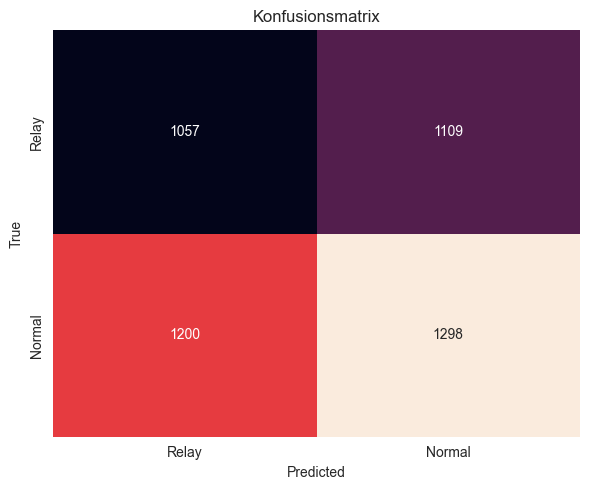

Training: 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


neuron (128, 64)
dropout 0.1
epoch num 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.61      0.53      0.56      2498
       Relay       0.53      0.61      0.57      2166

    accuracy                           0.56      4664
   macro avg       0.57      0.57      0.56      4664
weighted avg       0.57      0.56      0.56      4664



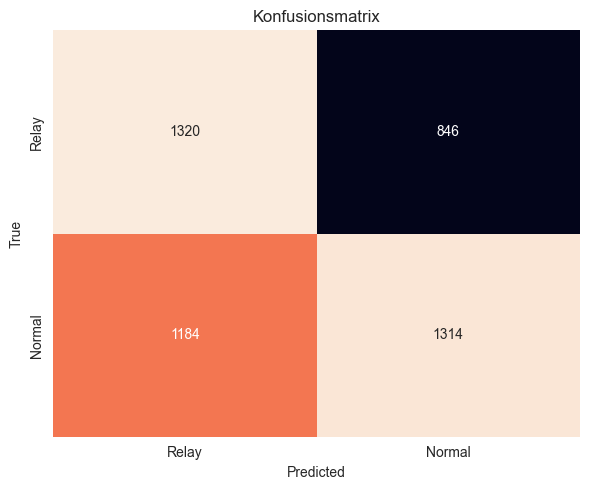

Training: 100%|██████████| 100/100 [02:23<00:00,  1.44s/it]


neuron (128, 64)
dropout 0.1
epoch num 100

Classification Report:
               precision    recall  f1-score   support

      Normal       0.56      0.52      0.54      2498
       Relay       0.49      0.54      0.52      2166

    accuracy                           0.53      4664
   macro avg       0.53      0.53      0.53      4664
weighted avg       0.53      0.53      0.53      4664



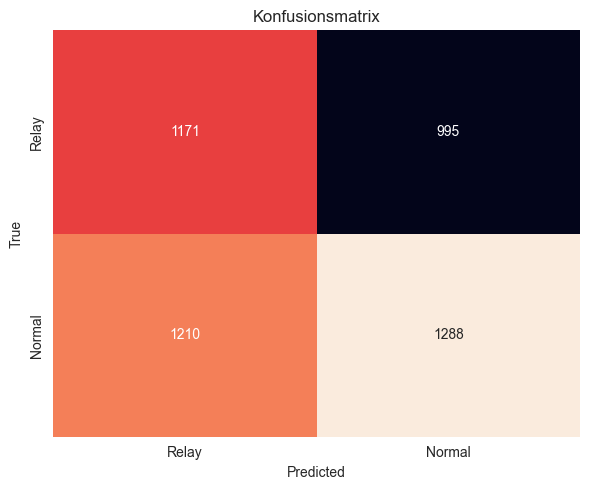

Training: 100%|██████████| 50/50 [01:19<00:00,  1.59s/it]


neuron (128, 64)
dropout 0.1
epoch num 50

Classification Report:
               precision    recall  f1-score   support

      Normal       0.59      0.52      0.55      2498
       Relay       0.51      0.58      0.55      2166

    accuracy                           0.55      4664
   macro avg       0.55      0.55      0.55      4664
weighted avg       0.55      0.55      0.55      4664



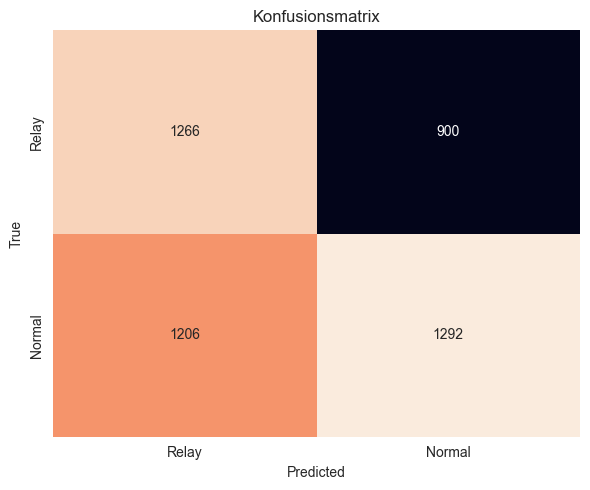

Training: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


neuron (128, 64)
dropout 0.2
epoch num 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.60      0.53      0.56      2498
       Relay       0.52      0.59      0.55      2166

    accuracy                           0.56      4664
   macro avg       0.56      0.56      0.56      4664
weighted avg       0.56      0.56      0.56      4664



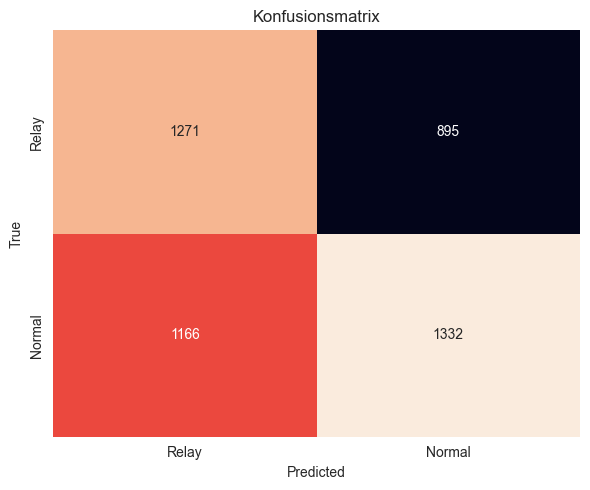

Training: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


neuron (128, 64)
dropout 0.2
epoch num 100

Classification Report:
               precision    recall  f1-score   support

      Normal       0.58      0.51      0.54      2498
       Relay       0.50      0.57      0.53      2166

    accuracy                           0.54      4664
   macro avg       0.54      0.54      0.54      4664
weighted avg       0.54      0.54      0.54      4664



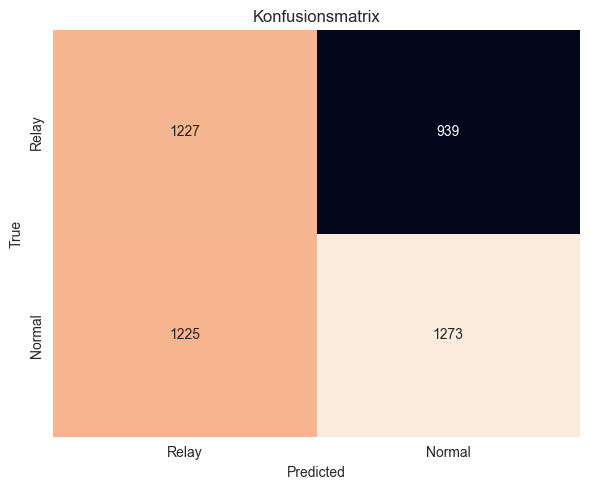

Training: 100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


neuron (128, 64)
dropout 0.2
epoch num 50

Classification Report:
               precision    recall  f1-score   support

      Normal       0.57      0.52      0.54      2498
       Relay       0.50      0.55      0.52      2166

    accuracy                           0.53      4664
   macro avg       0.53      0.54      0.53      4664
weighted avg       0.54      0.53      0.53      4664



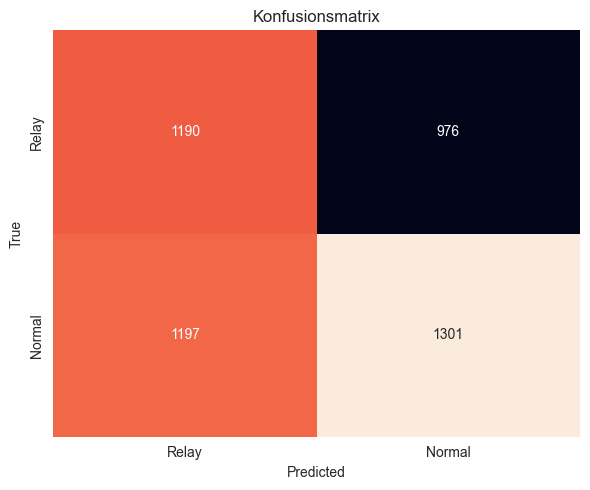

Training: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


neuron (128, 64)
dropout 0.3
epoch num 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.55      0.53      0.54      2498
       Relay       0.48      0.50      0.49      2166

    accuracy                           0.52      4664
   macro avg       0.52      0.52      0.52      4664
weighted avg       0.52      0.52      0.52      4664



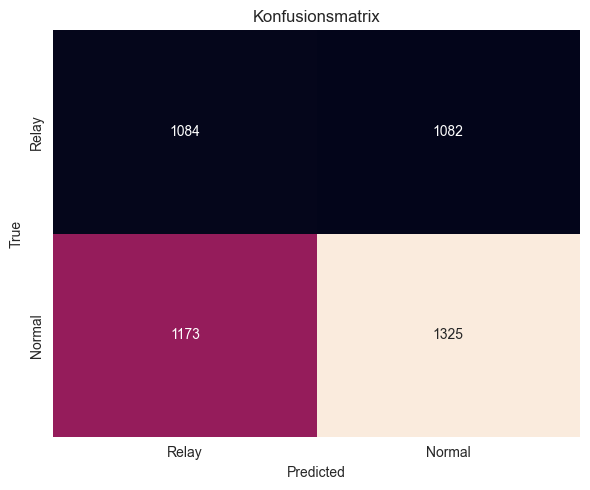

Training: 100%|██████████| 100/100 [02:24<00:00,  1.45s/it]


neuron (128, 64)
dropout 0.3
epoch num 100

Classification Report:
               precision    recall  f1-score   support

      Normal       0.54      0.52      0.53      2498
       Relay       0.47      0.49      0.48      2166

    accuracy                           0.51      4664
   macro avg       0.51      0.51      0.51      4664
weighted avg       0.51      0.51      0.51      4664



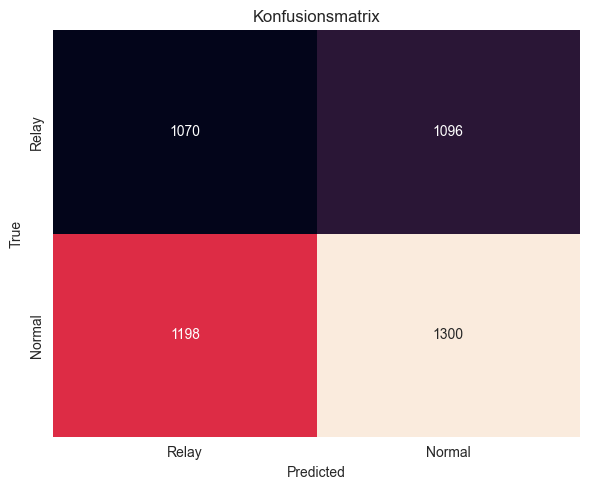

Training: 100%|██████████| 50/50 [01:34<00:00,  1.89s/it]


neuron (128, 64)
dropout 0.3
epoch num 50

Classification Report:
               precision    recall  f1-score   support

      Normal       0.55      0.53      0.54      2498
       Relay       0.48      0.50      0.49      2166

    accuracy                           0.52      4664
   macro avg       0.52      0.52      0.52      4664
weighted avg       0.52      0.52      0.52      4664



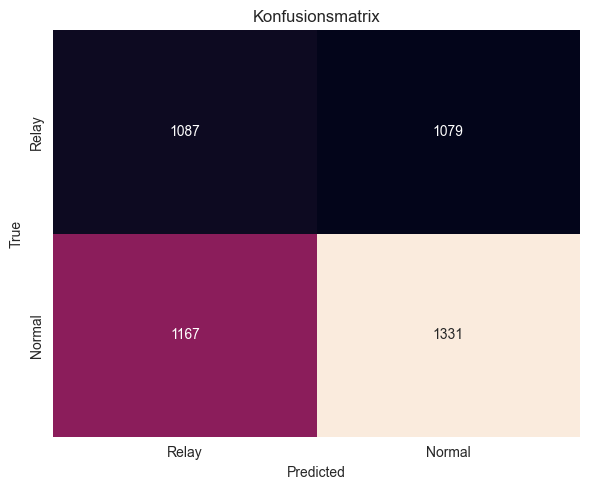

Training: 100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


neuron (256, 128)
dropout 0.1
epoch num 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.64      0.52      0.57      2498
       Relay       0.54      0.66      0.60      2166

    accuracy                           0.59      4664
   macro avg       0.59      0.59      0.59      4664
weighted avg       0.59      0.59      0.58      4664



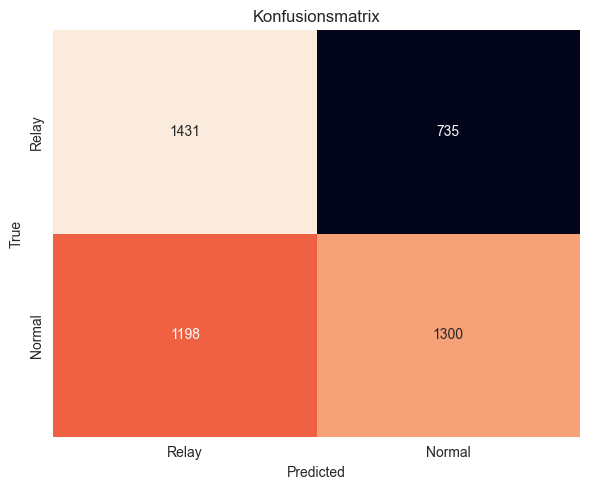

Training: 100%|██████████| 100/100 [03:26<00:00,  2.07s/it]


neuron (256, 128)
dropout 0.1
epoch num 100

Classification Report:
               precision    recall  f1-score   support

      Normal       0.58      0.52      0.55      2498
       Relay       0.50      0.57      0.53      2166

    accuracy                           0.54      4664
   macro avg       0.54      0.54      0.54      4664
weighted avg       0.54      0.54      0.54      4664



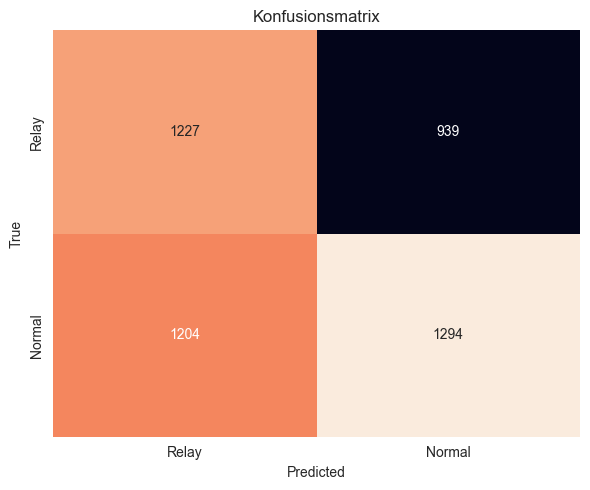

Training: 100%|██████████| 50/50 [01:59<00:00,  2.40s/it]


neuron (256, 128)
dropout 0.1
epoch num 50

Classification Report:
               precision    recall  f1-score   support

      Normal       0.65      0.53      0.58      2498
       Relay       0.55      0.67      0.60      2166

    accuracy                           0.59      4664
   macro avg       0.60      0.60      0.59      4664
weighted avg       0.60      0.59      0.59      4664



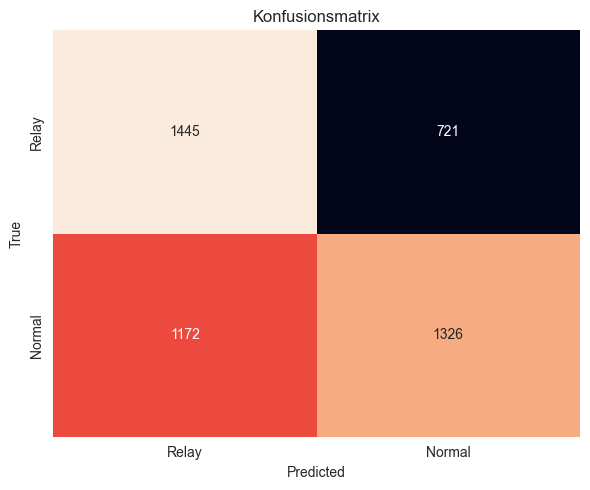

Training: 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


neuron (256, 128)
dropout 0.2
epoch num 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.63      0.53      0.57      2498
       Relay       0.54      0.64      0.58      2166

    accuracy                           0.58      4664
   macro avg       0.58      0.58      0.58      4664
weighted avg       0.59      0.58      0.58      4664



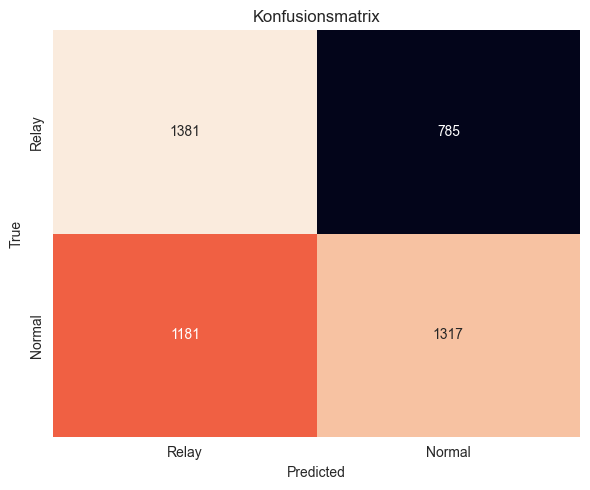

Training: 100%|██████████| 100/100 [05:21<00:00,  3.21s/it]


neuron (256, 128)
dropout 0.2
epoch num 100

Classification Report:
               precision    recall  f1-score   support

      Normal       0.57      0.52      0.55      2498
       Relay       0.50      0.55      0.52      2166

    accuracy                           0.53      4664
   macro avg       0.54      0.54      0.53      4664
weighted avg       0.54      0.53      0.54      4664



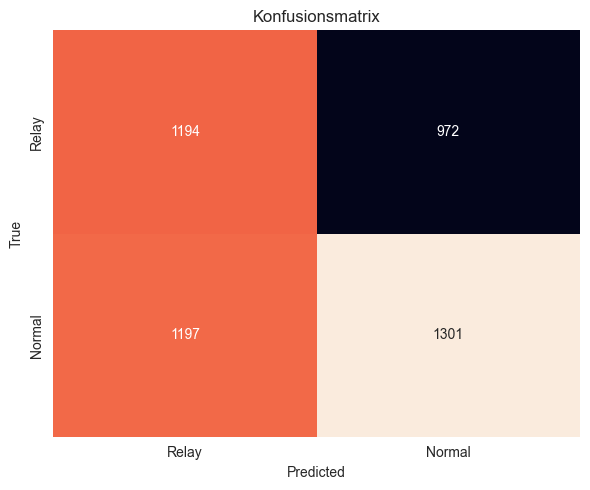

Training: 100%|██████████| 50/50 [02:46<00:00,  3.34s/it]


neuron (256, 128)
dropout 0.2
epoch num 50

Classification Report:
               precision    recall  f1-score   support

      Normal       0.59      0.54      0.56      2498
       Relay       0.52      0.57      0.54      2166

    accuracy                           0.55      4664
   macro avg       0.55      0.56      0.55      4664
weighted avg       0.56      0.55      0.55      4664



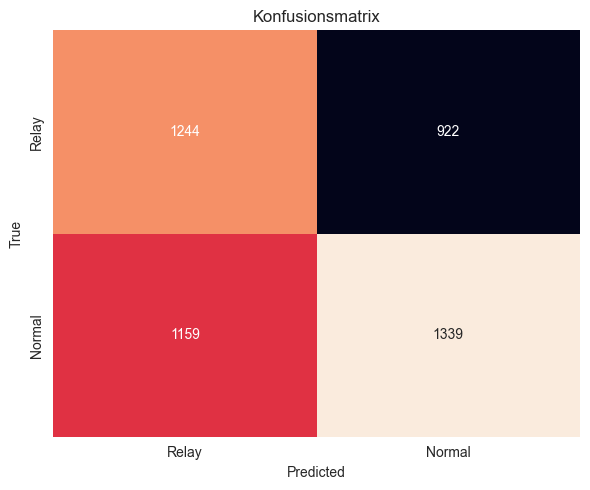

Training: 100%|██████████| 10/10 [00:34<00:00,  3.45s/it]


neuron (256, 128)
dropout 0.3
epoch num 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.56      0.52      0.54      2498
       Relay       0.49      0.53      0.51      2166

    accuracy                           0.52      4664
   macro avg       0.52      0.52      0.52      4664
weighted avg       0.53      0.52      0.52      4664



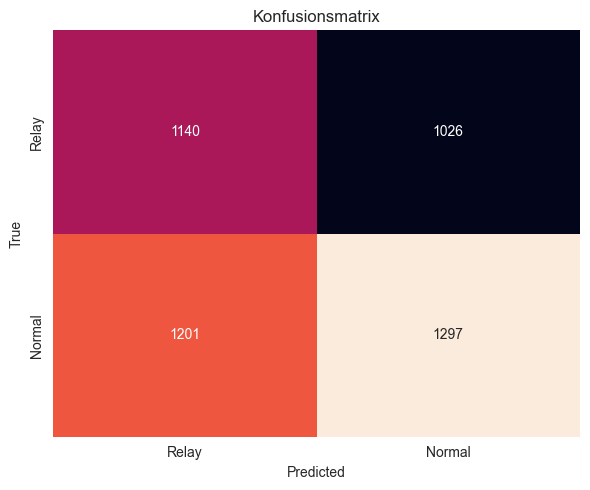

Training: 100%|██████████| 100/100 [06:29<00:00,  3.90s/it]


neuron (256, 128)
dropout 0.3
epoch num 100

Classification Report:
               precision    recall  f1-score   support

      Normal       0.57      0.52      0.54      2498
       Relay       0.50      0.54      0.52      2166

    accuracy                           0.53      4664
   macro avg       0.53      0.53      0.53      4664
weighted avg       0.53      0.53      0.53      4664



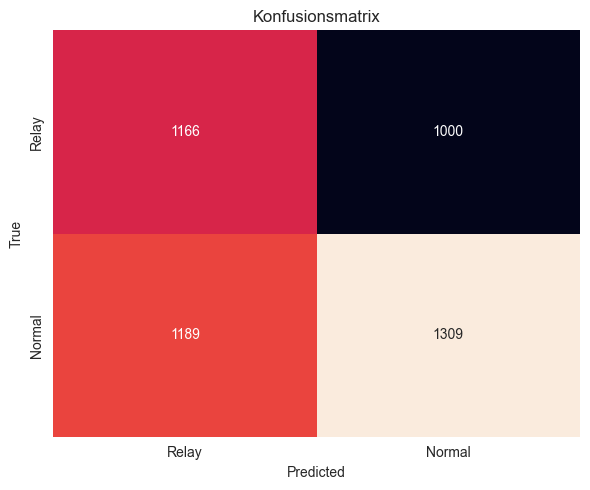

Training: 100%|██████████| 50/50 [02:49<00:00,  3.40s/it]


neuron (256, 128)
dropout 0.3
epoch num 50

Classification Report:
               precision    recall  f1-score   support

      Normal       0.56      0.52      0.54      2498
       Relay       0.49      0.54      0.51      2166

    accuracy                           0.53      4664
   macro avg       0.53      0.53      0.53      4664
weighted avg       0.53      0.53      0.53      4664



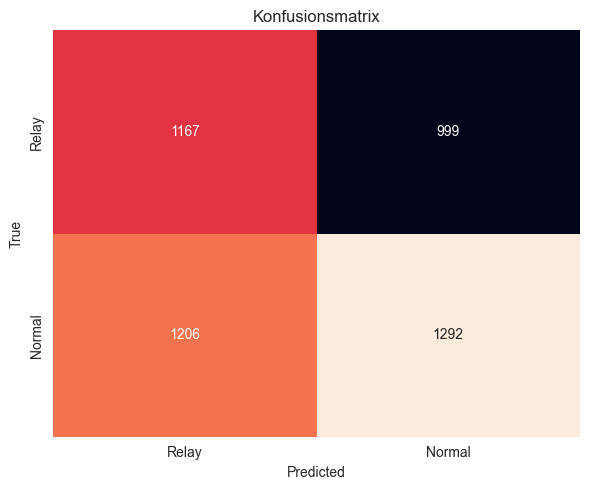

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from pyod.models.auto_encoder import AutoEncoder

# daten laden
normal_path = "transients/S01/1/Normal/q_data"
relay_path  = "transients/S01/1/Relay/q_data"

with h5py.File("datasets/transients_cleaned_padded.h5", "r") as f:
    normal_group = f[normal_path]
    relay_group  = f[relay_path]

    n_norm = normal_group["0"].shape[0]
    n_relay = relay_group["0"].shape[0]

    dataset_normal = np.zeros((49998, n_norm))
    dataset_relay  = np.zeros((49666, n_relay))

    for i in range(49998):
        dataset_normal[i] = normal_group[str(i)][:]
    for i in range(49666):
        try:
            dataset_relay[i] = relay_group[str(i)][:]
        except KeyError:
            continue

# daten definieren und skalieren
scaler = MinMaxScaler()

X_train               = dataset_normal[:47500]
X_test_normal         = dataset_normal[47500:]      # 2498 Normal
X_test_relay          = dataset_relay[47500:]        # 2166 Relay

scaler.fit(X_train)
X_train_scaled        = scaler.transform(X_train)
X_test_norm_scaled    = scaler.transform(X_test_normal)
X_test_relay_scaled   = scaler.transform(X_test_relay)

X_test_combined = np.vstack((X_test_normal, X_test_relay))
X_test_combined_scaled = np.vstack((X_test_norm_scaled, X_test_relay_scaled))

y_true = np.array([0] * len(X_test_normal) + [1] * len(X_test_relay))

# modell trainieren, contamination gibt an, wie viele outlier man im trainigsdatensatz hat
# contamination kann man bei reiner novelty detection zb auf 0.01 oder 0.05 setzen
for n in {(64, 32), (128, 64), (256, 128)}:
    for d in {0.1, 0.2, 0.3}:
        for e in {10, 50, 100}:
            clf = AutoEncoder(contamination=len(X_test_relay)/len(X_test_combined), hidden_neuron_list=n, dropout_rate=d, preprocessing=False, epoch_num=e)
            clf.fit(X_train_scaled)

            # pyod.predict: 0 = inlier, 1 = outlier
            y_pred = clf.predict(X_test_combined_scaled)

            # cm und report
            cm = confusion_matrix(y_true, y_pred, labels=[1,0])
            print(f"neuron {n}")
            print(f"dropout {d}")
            print(f"epoch num {e}")
            print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

            # plot
            plt.figure(figsize=(6,5))
            sns.heatmap(cm, annot=True, fmt="d",
                        xticklabels=["Relay","Normal"],
                        yticklabels=["Relay","Normal"],
                        cbar=False)
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.title("Konfusionsmatrix")
            plt.tight_layout()
            plt.show()

Training: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


neuron (256, 128)
dropout 0.1
epoch num 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.56      0.99      0.71      2498
       Relay       0.86      0.10      0.18      2166

    accuracy                           0.57      4664
   macro avg       0.71      0.54      0.45      4664
weighted avg       0.70      0.57      0.46      4664



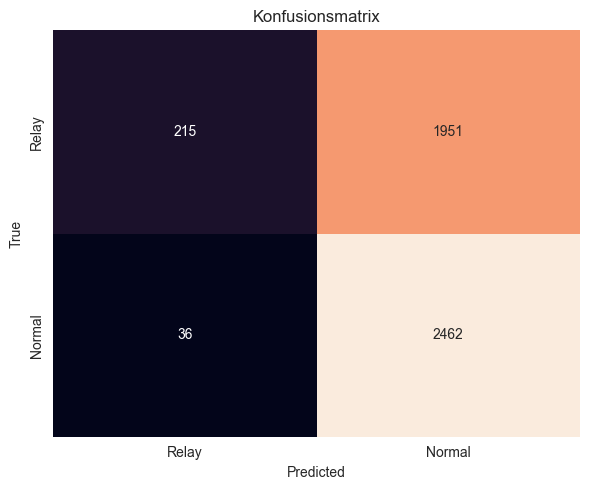

Training: 100%|██████████| 100/100 [04:00<00:00,  2.40s/it]


neuron (256, 128)
dropout 0.1
epoch num 100

Classification Report:
               precision    recall  f1-score   support

      Normal       0.56      0.99      0.71      2498
       Relay       0.85      0.09      0.17      2166

    accuracy                           0.57      4664
   macro avg       0.70      0.54      0.44      4664
weighted avg       0.69      0.57      0.46      4664



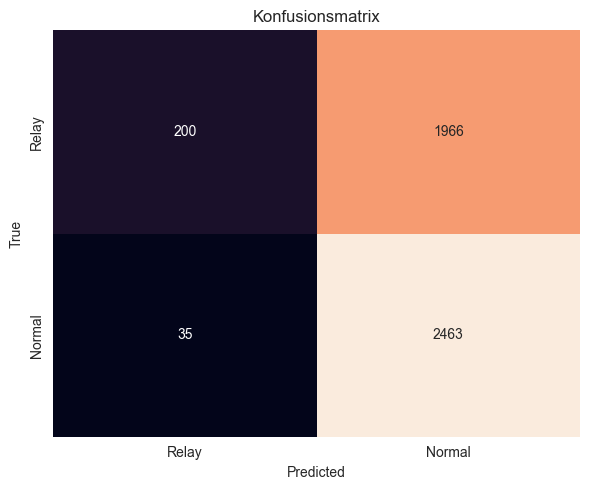

Training: 100%|██████████| 50/50 [01:29<00:00,  1.78s/it]


neuron (256, 128)
dropout 0.1
epoch num 50

Classification Report:
               precision    recall  f1-score   support

      Normal       0.57      0.99      0.72      2498
       Relay       0.89      0.13      0.22      2166

    accuracy                           0.59      4664
   macro avg       0.73      0.56      0.47      4664
weighted avg       0.72      0.59      0.49      4664



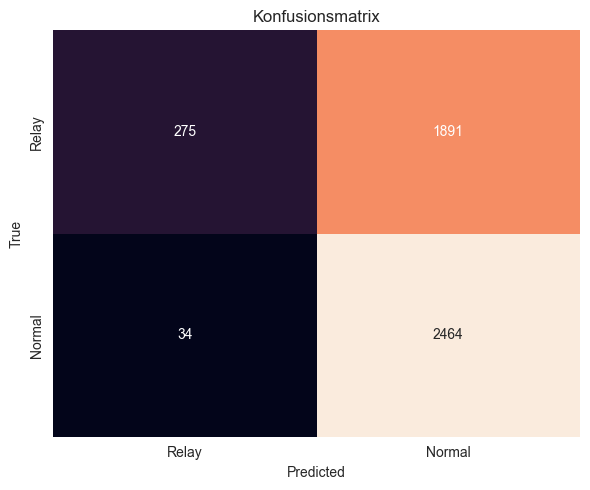

Training: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


neuron (256, 128)
dropout 0.2
epoch num 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.55      0.98      0.71      2498
       Relay       0.82      0.09      0.16      2166

    accuracy                           0.57      4664
   macro avg       0.69      0.54      0.43      4664
weighted avg       0.68      0.57      0.45      4664



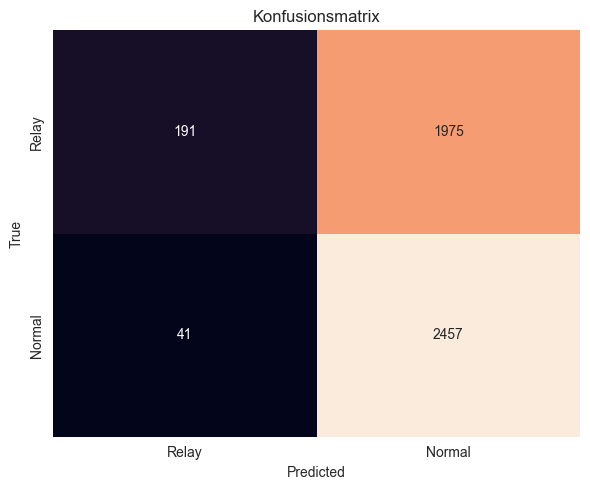

Training: 100%|██████████| 100/100 [03:29<00:00,  2.09s/it]


neuron (256, 128)
dropout 0.2
epoch num 100

Classification Report:
               precision    recall  f1-score   support

      Normal       0.55      0.99      0.71      2498
       Relay       0.83      0.08      0.14      2166

    accuracy                           0.56      4664
   macro avg       0.69      0.53      0.42      4664
weighted avg       0.68      0.56      0.44      4664



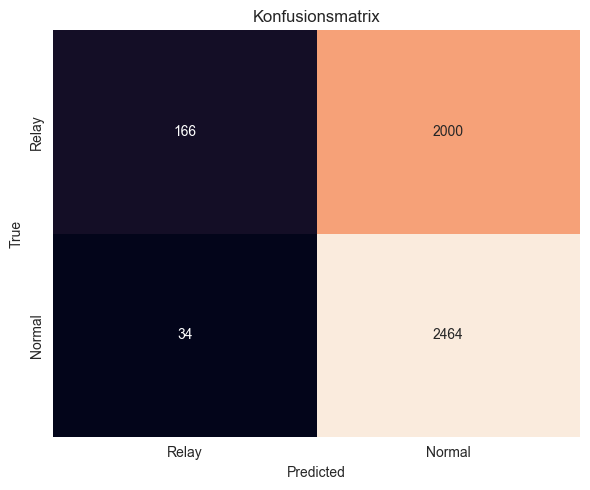

Training: 100%|██████████| 50/50 [02:02<00:00,  2.44s/it]


neuron (256, 128)
dropout 0.2
epoch num 50

Classification Report:
               precision    recall  f1-score   support

      Normal       0.55      0.99      0.70      2498
       Relay       0.81      0.06      0.11      2166

    accuracy                           0.56      4664
   macro avg       0.68      0.52      0.41      4664
weighted avg       0.67      0.56      0.43      4664



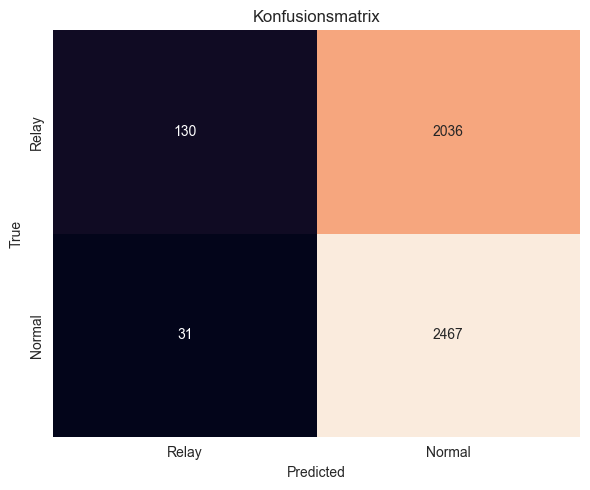

Training: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


neuron (256, 128)
dropout 0.3
epoch num 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.55      0.99      0.71      2498
       Relay       0.83      0.08      0.15      2166

    accuracy                           0.57      4664
   macro avg       0.69      0.53      0.43      4664
weighted avg       0.68      0.57      0.45      4664



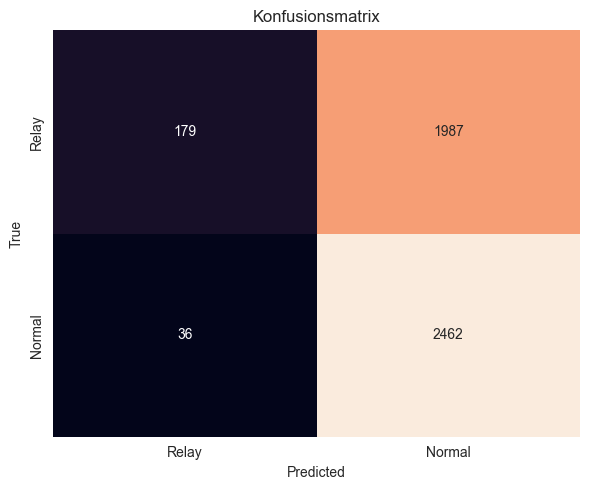

Training: 100%|██████████| 100/100 [03:20<00:00,  2.00s/it]


neuron (256, 128)
dropout 0.3
epoch num 100

Classification Report:
               precision    recall  f1-score   support

      Normal       0.55      0.99      0.71      2498
       Relay       0.81      0.07      0.13      2166

    accuracy                           0.56      4664
   macro avg       0.68      0.53      0.42      4664
weighted avg       0.67      0.56      0.44      4664



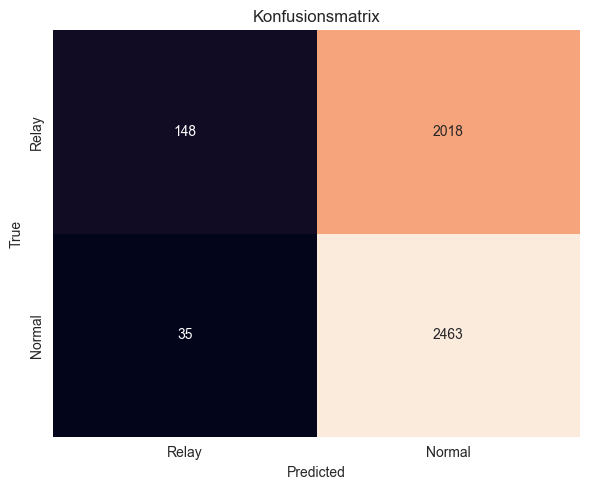

Training: 100%|██████████| 50/50 [01:38<00:00,  1.97s/it]


neuron (256, 128)
dropout 0.3
epoch num 50

Classification Report:
               precision    recall  f1-score   support

      Normal       0.55      0.99      0.71      2498
       Relay       0.83      0.07      0.13      2166

    accuracy                           0.56      4664
   macro avg       0.69      0.53      0.42      4664
weighted avg       0.68      0.56      0.44      4664



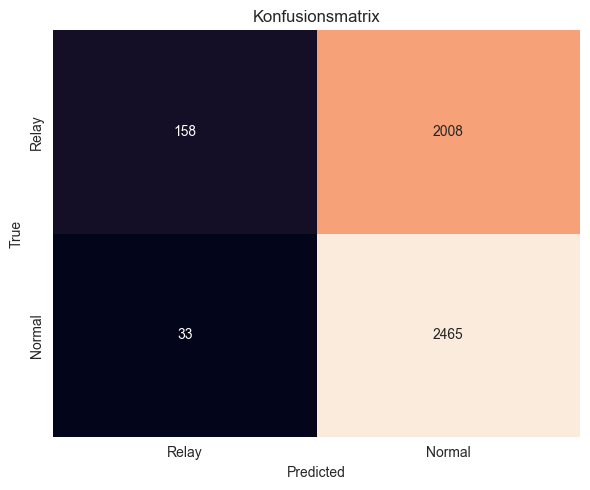

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from pyod.models.auto_encoder import AutoEncoder

# daten laden
normal_path = "transients/S01/1/Normal/q_data"
relay_path  = "transients/S01/1/Relay/q_data"

with h5py.File("datasets/transients_cleaned_padded.h5", "r") as f:
    normal_group = f[normal_path]
    relay_group  = f[relay_path]

    n_norm = normal_group["0"].shape[0]
    n_relay = relay_group["0"].shape[0]

    dataset_normal = np.zeros((49998, n_norm))
    dataset_relay  = np.zeros((49666, n_relay))

    for i in range(49998):
        dataset_normal[i] = normal_group[str(i)][:]
    for i in range(49666):
        try:
            dataset_relay[i] = relay_group[str(i)][:]
        except KeyError:
            continue

# daten definieren und skalieren
scaler = MinMaxScaler()

X_train               = dataset_normal[:47500]
X_test_normal         = dataset_normal[47500:]      # 2498 Normal
X_test_relay          = dataset_relay[47500:]        # 2166 Relay

scaler.fit(X_train)
X_train_scaled        = scaler.transform(X_train)
X_test_norm_scaled    = scaler.transform(X_test_normal)
X_test_relay_scaled   = scaler.transform(X_test_relay)

X_test_combined = np.vstack((X_test_normal, X_test_relay))
X_test_combined_scaled = np.vstack((X_test_norm_scaled, X_test_relay_scaled))

y_true = np.array([0] * len(X_test_normal) + [1] * len(X_test_relay))

# modell trainieren, contamination gibt an, wie viele outlier man im trainigsdatensatz hat
# contamination kann man bei reiner novelty detection zb auf 0.01 oder 0.05 setzen
for d in {0.1, 0.2, 0.3}:
    for e in {10, 50, 100}:
        clf = AutoEncoder(contamination=0.01, hidden_neuron_list=(256, 128), dropout_rate=d, preprocessing=False, epoch_num=e)
        clf.fit(X_train_scaled)

        # pyod.predict: 0 = inlier, 1 = outlier
        y_pred = clf.predict(X_test_combined_scaled)

        # cm und report
        cm = confusion_matrix(y_true, y_pred, labels=[1,0])
        print(f"neuron {n}")
        print(f"dropout {d}")
        print(f"epoch num {e}")
        print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

        # plot
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d",
                    xticklabels=["Relay","Normal"],
                    yticklabels=["Relay","Normal"],
                    cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Konfusionsmatrix")
        plt.tight_layout()
        plt.show()